# Assignment 1: NARMA10 task

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import mean_squared_error


Load the datset

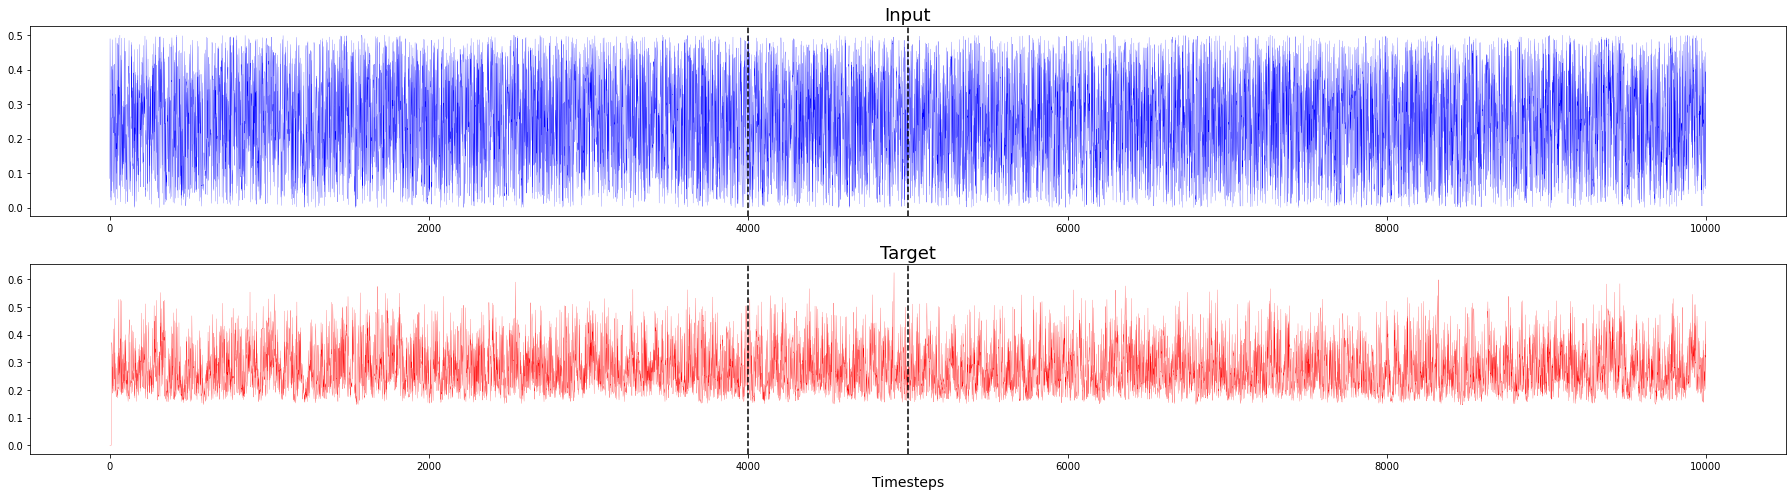

In [62]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

## Reservoir

In [63]:
def esn (hyperparams):
    Nh = int(hyperparams[0])
    rho = hyperparams[1]
    omega_x = hyperparams[2]
    omega_b = hyperparams[3]
    l = hyperparams[4]
    Nx = 1
    dh = 0.3
    dx = 0.5
    db = 0.5 
    valid_mse_hist = []
    ntrials = 5
    for i in range (ntrials):
        # Initialize weights Wx and Wh
        Wx = sparse.rand(Nh, Nx, density=dx)
        Wx = Wx.toarray()
        Wx = 2 * Wx - 1
        Wx = omega_x * Wx

        Wh = sparse.rand(Nh, Nh, density=dh)
        Wh = Wh.toarray()
        Wh = 2 * Wh - 1
        Wh = rho * (Wh / np.max(np.abs(np.linalg.eig(Wh)[0])))


        # bias 
        b = sparse.rand(Nh, Nx, density=db) #deve corrispondere a Wx
        b = b.toarray()
        b = 2 * b - 1
        b = omega_b * b


        #Run the reservoir on the input stream
        #b = np.ones_like(Wx) 


        # Initialize state vector and hidden state history
        state = np.zeros((Nh, 1))
        H = state.copy()


        for t in range(len(x_train)):
            state = np.tanh(Wh.dot(state) + Wx.dot(x_train[t]) + b)
            H = np.hstack((H, state))

        #print(b.shape)
        #print(Wx.shape)
        #print(H.shape)

        #discard the washout
        washout_size = 100 #va bene tenerlo costante
        H = H[:, (washout_size+1):]
        #print(H.shape)

        Y = y_train[washout_size:]
        #print(Y.shape)
        #train the readout

        Wo = np.dot(np.dot(Y,H.T),np.linalg.inv(np.dot(H,H.T)+l*np.identity(len(np.dot(H,H.T)))))
        o_tr = np.dot(Wo, H)
        err_tr = mean_squared_error(Y, o_tr)

        '''
        plt.figure(figsize = (25,7))
        plt.plot(o_tr[:200])
        plt.plot(Y[:200])
        plt.title(f'MSE = {err_tr}')
        '''

        H = state

        for t in range(len(x_valid)):
            state = np.tanh(Wh.dot(state) + Wx.dot(x_valid[t]) + b)
            H = np.hstack((H, state))

        H = H[:, 1:]

        o_valid = np.dot(Wo, H)
        err_valid = mean_squared_error(y_valid, o_valid)

        '''
        plt.figure(figsize = (25,7))
        plt.plot(o_valid[:200])
        plt.plot(y_valid[:200])
        plt.title(f'MSE = {err_valid}')
        '''
        #print(f'{i}: train mse={err_tr};    val mse={err_valid}')
        valid_mse_hist.append(err_valid)

    avg_val_mse = np.mean(valid_mse_hist)
    #print(f'average validation mse = {avg_val_mse}')
    return avg_val_mse

In [64]:
# anche il bias deve essere sparse?

#hyperparameters
Nh = [100,200] #number of reservoir units
rho = [0.2,0.5,0.9,0.99,1.1,1.3,1.7] #spectral radius
omega_x = [0.1,1,10] #?? #input scaling
omega_b = [0.1,1,10] #?? #bias scaling
l = [0.1,0.5,1,2] #lambda tickhonov regularization coefficient




#compute all the possible combinations
p = np.array(np.meshgrid(Nh, rho, omega_x, omega_b, l)).T.reshape(-1,5)

print(f'The search space is composed of {len(p)} combinations of hyperparameters')

The search space is composed of 504 combinations of hyperparameters


In [65]:
min_mae = 1e3
best_hp = []
for i in range(len(p)):
    hyperparameters = p[i,:]
    mae = esn(hyperparameters)
    if mae < min_mae:
        min_mae = mae
        best_hp = hyperparameters
    print(f'iteration {i}, mae = {mae}, best mae so far = {min_mae}')

print(f' BEST HYPERPARAMS{best_hp} corresponding to mae = {min_mae}')

In [ ]:
'''
H = state

for t in range(len(x_test)):
    state = np.tanh(Wh.dot(state) + Wx.dot(x_test[t]) + b)
    H = np.hstack((H, state))

o_test = np.dot(Wo, H)
err_test = mean_squared_error(y_test, o_test[1:])

'''


KeyboardInterrupt: 

Text(0.5, 1.0, 'MSE = 0.00432804678908335')

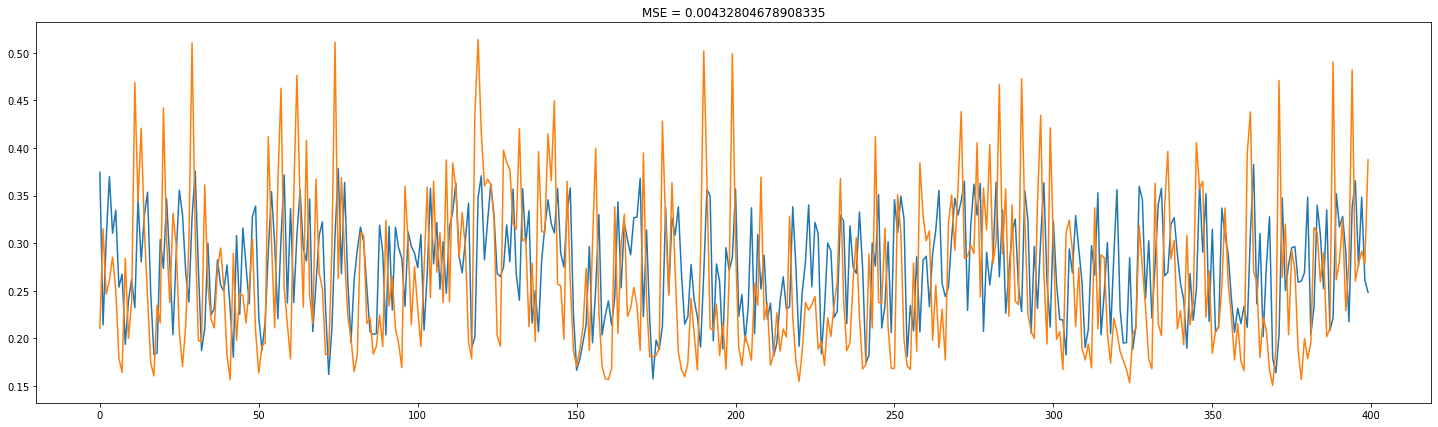

In [ ]:
plt.figure(figsize = (25,7))

plt.plot(o_test[:400])
plt.plot(y_test[:400])
plt.title(f'MSE = {err_test}')